In [1]:
import nltk.data
import operator
import string
import math
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from astropy.convolution import convolve, Gaussian1DKernel
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models, similarities

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
wordnet_lemmatizer = WordNetLemmatizer()


## Asociación de palabras

In [2]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def tokenize(text):
    res = []
    tags = []
    sentences = sent_detector.tokenize(text.lower())
    for sentence in sentences:
        text = nltk.word_tokenize(sentence)
        pos_tags = nltk.pos_tag(text)
        for pos_tag in pos_tags:
            tag = get_wordnet_pos(pos_tag[1])
            if not tag is None:
                lemma = wordnet_lemmatizer.lemmatize(pos_tag[0], tag)
                res.append(lemma)
                pos_tag = (lemma, tag)
                tags.append(pos_tag)                
    return res, tags


### Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario (``<DOCNO>``: ``<TEXT>``)

In [3]:
apCorpus = {}
with open('ap/ap.txt', 'r') as ap:
    nextDoc = ap.readline()
    while nextDoc:
        docNumber = ap.readline().split(' ')[1]
        ap.readline()
        text = ap.readline().strip()
        ap.readline()
        ap.readline()
        apCorpus[docNumber], _ = tokenize(text)
        nextDoc = ap.readline()


### Calcular el tamaño del vocabulario

In [4]:
apWords = set()
apWordsFrequencies = {}
apCorpusSize = 0
for _, text in apCorpus.iteritems():
    apCorpusSize += len(text)
    tokens = set(text)
    apWords |= tokens
    for word in tokens:
        if not word in apWordsFrequencies:
            apWordsFrequencies[word] = 0
        apWordsFrequencies[word] += text.count(word)

print 'Tamaño del vocabulario:', len(apWords)
print 'Tamaño del corpus:', apCorpusSize

Tamaño del vocabulario: 32231
Tamaño del corpus: 571642


### Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada

In [5]:
apTop500Freq = []
for i, (word, count) in enumerate(sorted(apWordsFrequencies.iteritems(), key=operator.itemgetter(1), reverse = True)):
    if i >= 500:
        break
    apTop500Freq.append(word)

In [6]:
window = 5
bigram_measures = BigramAssocMeasures()
finders = {}
for doc, text in apCorpus.iteritems():
    finder = BigramCollocationFinder.from_words(text, window_size = window)
    finder.apply_ngram_filter(lambda w1, w2: w1 not in apTop500Freq or w2 not in apTop500Freq)
    finders[doc] = finder


In [7]:
sum_scores = {}
for _, finder in finders.iteritems():
    for score in finder.score_ngrams(bigram_measures.pmi):
        tupled = tuple(sorted(score[0]))
        if not tupled in sum_scores:
            sum_scores[tupled] = (score[1], 1)
        else:
            sum_scores[tupled] = (sum_scores[tupled][0] + score[1], sum_scores[tupled][1] + 1)

for pair, scores in sum_scores.iteritems():
    sum_scores[pair] = scores[0] / float(scores[1])

maximum = max(sum_scores, key = sum_scores.get)
print maximum, "%.2f" % sum_scores[maximum]

('germany', u'plan') 7.60


## Información Léxica

### Procesar el libro de Darwin ON THE ORIGIN OF SPECIES, tokenizando eliminando signos de puntuación

In [8]:
darwin_tokens = None
darwin_tags = None
word_freq_darwin = {}
with open('darwin/ONTHEORIGINOFSPECIES.txt', 'r') as darwintext:
    darwin_tokens, darwin_tags = tokenize(darwintext.read().decode('utf-8'))
    for w in set(darwin_tokens):
        word_freq_darwin[w] = darwin_tokens.count(w)


### Siguiendo el artículo, calcular la autocorrelación para estimar la distribución de las palabras: 'island', 'instinct', 'more' a lo largo del texto

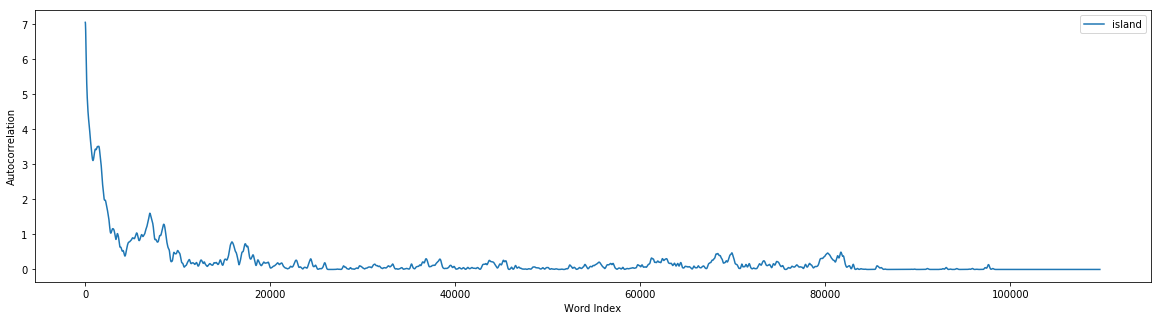

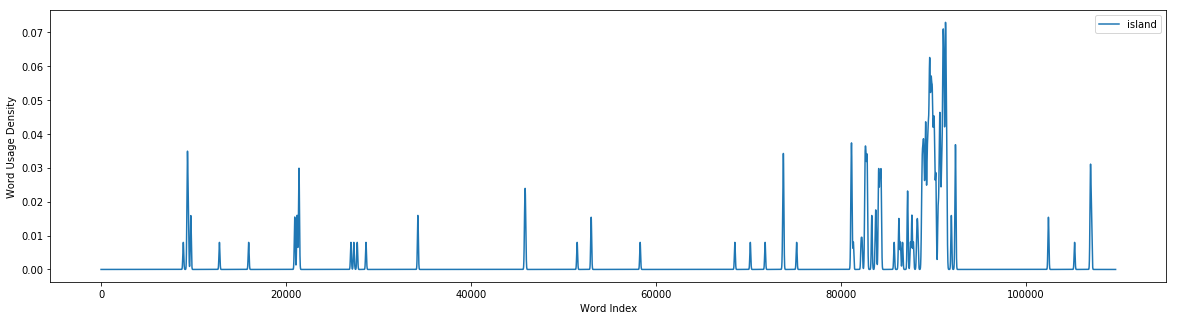

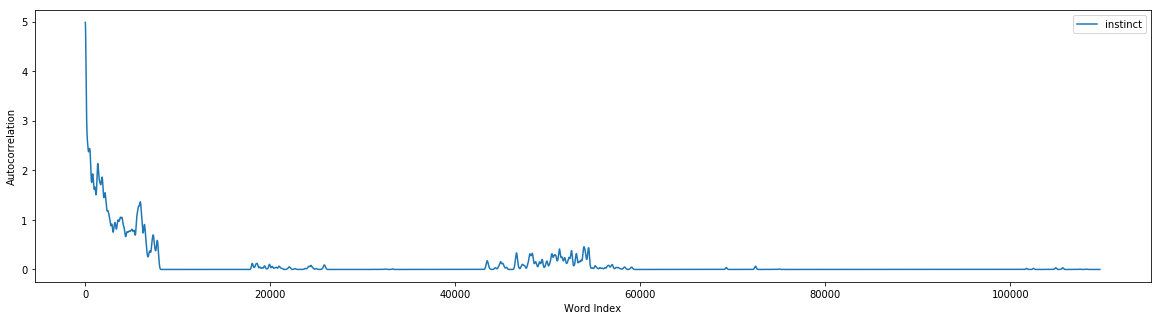

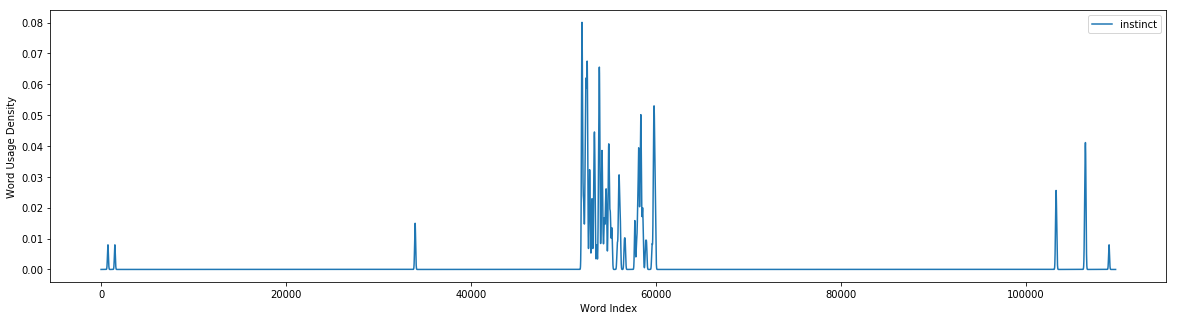

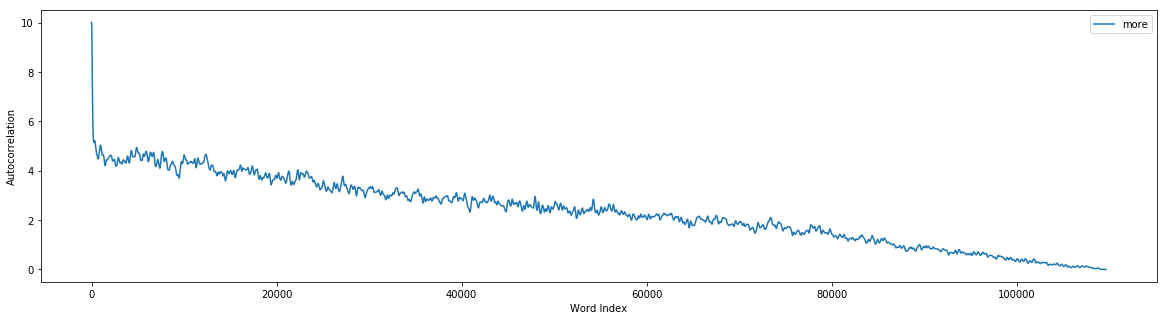

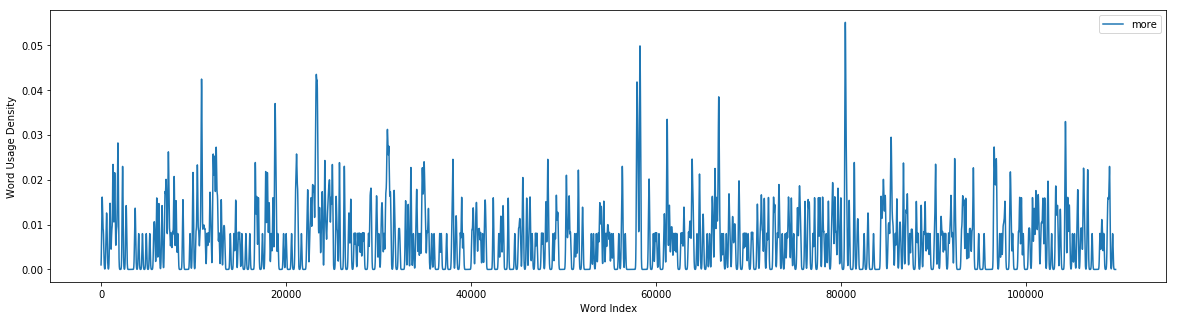

In [9]:
relevant_words = ['island', 'instinct', 'more']
plant_occurrences = [1 if w == relevant_words[0] else 0 for w in darwin_tokens]
instinct_occurrences = [1 if w == relevant_words[1] else 0 for w in darwin_tokens]
more_occurrences = [1 if w == relevant_words[2] else 0 for w in darwin_tokens]

sigma = 50

gauss_kernel = Gaussian1DKernel(sigma)
smoothed_plant = convolve(plant_occurrences, gauss_kernel)
smoothed_instinct = convolve(instinct_occurrences, gauss_kernel)
smoothed_more = convolve(more_occurrences, gauss_kernel)

def autocorr(x):
    result = np.correlate(x, x, mode = 'full')
    return result[len(result) / 2:]

plt.subplots(figsize=(20,5))
plt.plot(autocorr(smoothed_plant), label = relevant_words[0])
plt.legend()
plt.xlabel('Word Index')
plt.ylabel('Autocorrelation')
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(smoothed_plant, label = relevant_words[0])
plt.legend()
plt.xlabel('Word Index')
plt.ylabel('Word Usage Density')
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(autocorr(smoothed_instinct), label = relevant_words[1])
plt.legend()
plt.xlabel('Word Index')
plt.ylabel('Autocorrelation')
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(smoothed_instinct, label = relevant_words[1])
plt.legend()
plt.xlabel('Word Index')
plt.ylabel('Word Usage Density')
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(autocorr(smoothed_more), label = relevant_words[2])
plt.legend()
plt.xlabel('Word Index')
plt.ylabel('Autocorrelation')
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(smoothed_more, label = relevant_words[2])
plt.legend()
plt.xlabel('Word Index')
plt.ylabel('Word Usage Density')
plt.show()

### Armar una función que reciba una lista de tokens, una lista de palabras y un tamaño de ventana y devuelva una lista de probabilidades de encontrar la palabra en cada ventana para cada palabra pasada por parámetro

In [10]:
def prob_in_window(tokens, words, window_size):
    res = {}
    chunks = [tokens[i:i + window_size] for i in xrange(0, len(tokens), window_size)]
    for i, chunk in enumerate(chunks):
        probs_in_chunk = {}
        for w in words:
            probs_in_chunk[w] = chunk.count(w) / float(len(chunk))
        res[i] = probs_in_chunk
    return res


### Calcular la entropía de la distribución de palabras seleccionadas para distintos tamaños de ventana

In [11]:
def entropies_parts(tokens, words, parts):
    probs = prob_in_window(tokens, words, len(tokens) / parts)
    res = {}
    for word in words:
        res[word] = sc.stats.entropy([probs[i][word] for i in range(0, parts)])
    return res

probs_w = entropies_parts(darwin_tokens, set(darwin_tokens), 64)


/Users/personal/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


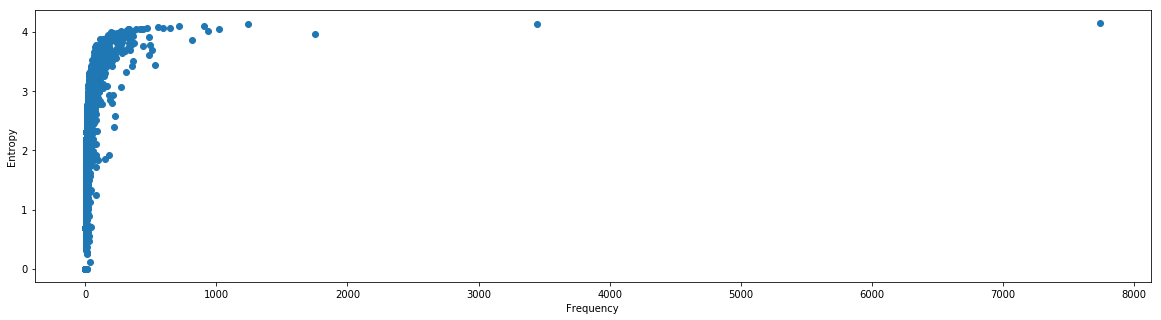

In [12]:
plt.subplots(figsize=(20,5))
plt.scatter([word_freq_darwin[w] for w in probs_w.keys()], probs_w.values())
plt.xlabel('Frequency')
plt.ylabel('Entropy')
plt.show()

### Generar una versión randomizada del texto, y medir la entropía de las palabras randomizadas

In [13]:
shuffled = random.sample(darwin_tokens, len(darwin_tokens))

probs_w_shuffled = entropies_parts(shuffled, set(shuffled), 64)


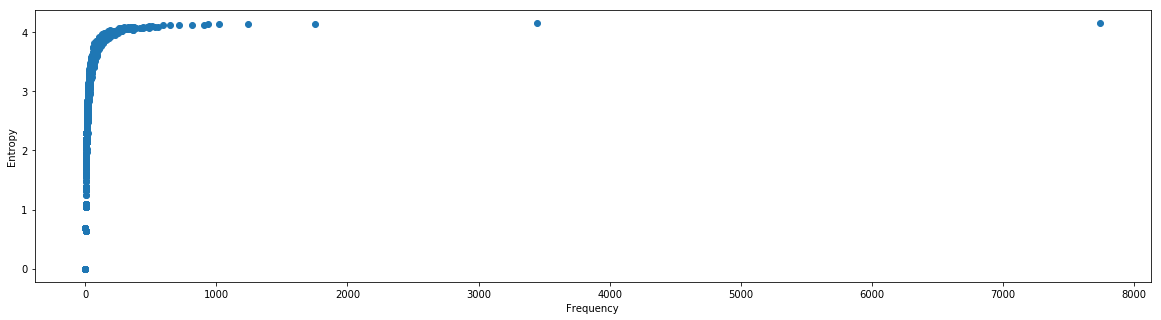

In [14]:
plt.subplots(figsize=(20,5))
plt.scatter([word_freq_darwin[w] for w in probs_w_shuffled.keys()], probs_w_shuffled.values())
plt.xlabel('Frequency')
plt.ylabel('Entropy')
plt.show()

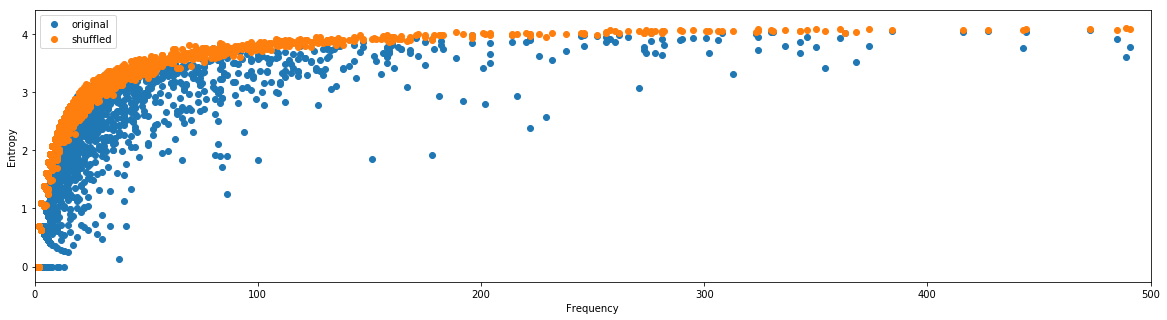

In [15]:
plt.subplots(figsize=(20,5))
plt.scatter([word_freq_darwin[w] for w in probs_w.keys()], probs_w.values(), label = 'original')
plt.scatter([word_freq_darwin[w] for w in probs_w_shuffled.keys()], probs_w_shuffled.values(), label = 'shuffled')
plt.legend()
plt.xlim(0, 500)
plt.xlabel('Frequency')
plt.ylabel('Entropy')
plt.show()

In [16]:
diffs = [(math.fabs(probs_w[w] - probs_w_shuffled[w]), w) for w in probs_w.keys()]
topTen = [w for (_, w) in sorted(diffs, reverse = True)[:10]]
print "Top ten most different entropry:"
for i in topTen:
    print i


Top ten most different entropry:
grandeur
slave
f.
cuckoo
wax
sanguinea
worker
cell
pedicellariae
float


## Word embeddings, distancia semántica y WordNet

### Utilizando el test WordSim353, comparar el rendimiento entre LSA y Word2Vec
### Comparar los distintos word embeddings con las medidas definidas en WordNet

In [17]:
dictionary = corpora.Dictionary(nltk.corpus.brown.sents())
# corpora.MmCorpus.serialize('corpus.mm', (dictionary.doc2bow(text) for text in nltk.corpus.brown.sents()))
corpus = corpora.MmCorpus('corpus.mm')

lsi = models.LsiModel(corpus, id2word = dictionary, num_topics = 300)

# word2vec = models.Word2Vec(nltk.corpus.brown.sents())
# word2vec.save('word2vec_model.model')
word2vec = models.Word2Vec.load('word2vec_model.model')

In [18]:
new_docs = []
with open('wordsim353_sim_rel/wordsim353_agreed.txt', 'r') as ws:
    line = ws.readline()
    while line.startswith('#'):
        line = ws.readline()
    while line:
        splitted = line.strip().split('\t')[1:]
        splitted[2] = float(splitted[2])
        new_docs.append(splitted)
        line = ws.readline()

# -1, 1 standarization
def standarize(records, index):
    standarization = [d[index] for d in records]
    max_standarization = max(standarization)
    min_standarization = min(standarization)
    for d in records:
        d[index] = 2 * ((d[index] - min_standarization) / (max_standarization - min_standarization)) - 1

def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

for new_doc in new_docs:
    word_0 = new_doc[0]
    word_1 = new_doc[1]
    vec_lsi_0 = [v for (k, v) in lsi[dictionary.doc2bow([word_0])]]
    vec_lsi_1 = [v for (k, v) in lsi[dictionary.doc2bow([word_1])]]
    try:
        new_doc.append(cosine_similarity(vec_lsi_0, vec_lsi_1))
        new_doc.append(word2vec.wv.similarity(word_0, word_1))
        new_doc.append(wordnet.synsets(word_0)[0].path_similarity(wordnet.synsets(word_1)[0]))
        new_doc.append(wordnet.synsets(word_0)[0].lch_similarity(wordnet.synsets(word_1)[0]))
        new_doc.append(wordnet.synsets(word_0)[0].wup_similarity(wordnet.synsets(word_1)[0]))        
        
    except Exception:
        continue
    
new_docs = filter(lambda d: len(d) == 8, new_docs)

for i in xrange(2, 8):
    standarize(new_docs, i)


In [19]:
columnWordEmbeddingsNames = ['WordSim', 'LSA', 'Word2Vec', 'path_similarity', 'lch_similarity', 'wup_similarity']
columnWordEmbeddingsDistanceNames = ['LSA Distance', 'Word2Vec Distance', 'path_similarity Distance', 'lch_similarity Distance', 'wup_similarity Distance']

df = pd.DataFrame(columns = columnWordEmbeddingsNames)

for d in new_docs:
    df = df.append((pd.Series( \
        { \
            columnWordEmbeddingsNames[0]: d[2], \
            columnWordEmbeddingsNames[1]: d[3], \
            columnWordEmbeddingsNames[2]: d[4], \
            columnWordEmbeddingsNames[3]: d[5], \
            columnWordEmbeddingsNames[4]: d[6], \
            columnWordEmbeddingsNames[5]: d[7], \
            columnWordEmbeddingsDistanceNames[0]: math.fabs(d[2]-d[3]), \
            columnWordEmbeddingsDistanceNames[1]: math.fabs(d[2]-d[4]), \
            columnWordEmbeddingsDistanceNames[2]: math.fabs(d[2]-d[5]), \
            columnWordEmbeddingsDistanceNames[3]: math.fabs(d[2]-d[6]), \
            columnWordEmbeddingsDistanceNames[4]: math.fabs(d[2]-d[7]), \
        })).rename(d[0] + ' - ' + d[1]))

display(df)


,WordSim,LSA,Word2Vec,path_similarity,lch_similarity,wup_similarity,LSA Distance,Word2Vec Distance,lch_similarity Distance,path_similarity Distance,wup_similarity Distance
love - sex,0.317125,-0.519881,0.013835,-0.929825,-0.658964,-0.870445,0.837006,0.303290,0.976089,1.246949,1.187570
tiger - cat,0.439746,-0.692747,-0.272197,-0.913876,-0.600874,-0.004785,1.132493,0.711944,1.040621,1.353622,0.444531
tiger - tiger,1.000000,1.000000,1.000000,1.000000,1.000000,0.447368,0.000000,0.000000,0.000000,0.000000,0.552632
book - paper,0.463002,-0.804938,0.368577,-0.943320,-0.712402,-0.657895,1.267940,0.094425,1.175404,1.406322,1.120897
plane - car,0.105708,-0.693821,0.368236,-0.871345,-0.466903,0.263158,0.799529,0.262528,0.572611,0.977053,0.157450
train - car,0.219873,-0.871572,0.604368,-0.842105,-0.388269,0.263158,1.091445,0.384495,0.608142,1.061978,0.043285
telephone - communication,0.471459,-0.550340,0.480817,-0.954887,-0.761878,-0.915789,1.021799,0.009358,1.233337,1.426346,1.387248
television - radio,0.317125,-0.626340,0.873539,-0.403509,0.266548,0.778947,0.943465,0.556415,0.050576,0.720634,0.461823
media - radio,0.454545,-0.662373,0.777486,-0.578947,0.074487,0.609907,1.116918,0.322940,0.380058,1.033493,0.155362
drug - abuse,0.334038,-0.701252,0.603843,-0.943320,-0.712402,-0.894737,1.035290,0.269805,1.046440,1.277358,1.228775


In [20]:
columnNames = ['Mean', 'Stdev']
dfMeasures = pd.DataFrame(columns = columnNames)

for name in columnWordEmbeddingsNames:
    dfMeasures = dfMeasures.append((pd.Series( \
        { \
             columnNames[0]: df[name].mean(), \
             columnNames[1]: df[name].std(), \
        })).rename(name))

display(dfMeasures)

,Mean,Stdev
WordSim,0.118353,0.438168
LSA,-0.587664,0.227639
Word2Vec,0.310379,0.439185
path_similarity,-0.819951,0.284935
lch_similarity,-0.475181,0.368144
wup_similarity,-0.373436,0.523322


In [21]:
for index, row in dfMeasures.iterrows():
    name = columnWordEmbeddingsNames[0]
    if index != name:
        print 'Mean difference', name, 'vs', index, math.fabs(row[columnNames[0]] - dfMeasures[columnNames[0]][0])

Mean difference WordSim vs LSA 0.706017345917
Mean difference WordSim vs Word2Vec 0.192026280058
Mean difference WordSim vs path_similarity 0.938304559401
Mean difference WordSim vs lch_similarity 0.593534170477
Mean difference WordSim vs wup_similarity 0.491788774317


In [22]:
idx_diff = 6
counts = [0, 0, 0, 0, 0]
for _, row in df.iterrows():
    minimum_idx = [i - idx_diff for i in xrange(idx_diff, len(row)) if row[i] == min(row[-5:])]
    for i in minimum_idx:
        counts[i] += 1

counts = map(lambda x: x / float(len(df)), counts)
print counts

[0.13257575757575757, 0.5075757575757576, 0.14015151515151514, 0.045454545454545456, 0.20075757575757575]
